# Find changepoints in raw positions

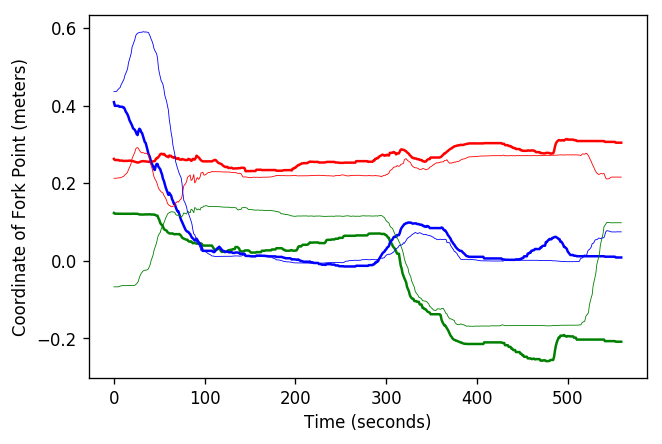

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
fig=plt.figure(dpi= 120, facecolor='w', edgecolor='k')
#### read in the txt file
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
raw_data = np.loadtxt('../data/spoon_poses_both.txt', delimiter=',')
#plt.plot(raw_data[:,(1,2,3,8,9,10)])
# Transform from second robot to frame of first robot
import transforms3d as t3d
q = [0, 0, 0, 1] # 180 degree rotation around z axis (w,x,y,z)
M = t3d.quaternions.quat2mat(q) # from this module
T = [[0.45, 0.06, 0]]
transform = np.concatenate((np.concatenate((M,np.transpose(T)),1),[[0,0,0,1]]))
# Plot the trajectories in the same coordinate frame
time = np.size(raw_data,0)
homogeneous_follower = np.transpose(np.concatenate((raw_data[:,1:4],np.ones((time,1))),1))
follower = np.transpose(np.dot(transform, homogeneous_follower))
follower.shape
same_frame_data = np.concatenate((raw_data[:,8:11],follower[:,0:3]),1)
from cycler import cycler
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = cycler(color='rgb')
relevant_indices = range(0,len(raw_data))#range(250,400)#
plt.plot(raw_data[relevant_indices,8:11])
plt.plot(follower[relevant_indices,0:3],linewidth=0.5)
plt.xlabel("Time (seconds)")
plt.ylabel("Coordinate of Fork Point (meters)");

# Model second arm relative to first

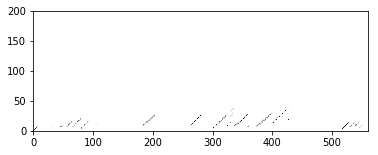

In [2]:
import sys
import numpy as np
sys.path.insert(0, "../scripts")
import changepoint_detector.gaussian_model as gm
import changepoint_detector.changepoint_detector as chd
num_variables=3
max_duration = len(relevant_indices) + 2
# set apriori parameters
apriori_n = 0.001
apriori_mean = np.zeros(num_variables)
apriori_ssd = np.ones(num_variables)/100000

import changepoint_detector.multiple_model_changepoint_detector as mmchd
model_generator = gm.GaussianPredictor(num_variables, apriori_n, apriori_mean, apriori_n / 2, apriori_ssd / 2).Fit
model_generator_diff = gm.GaussianPredictor(num_variables, apriori_n, apriori_mean, apriori_n / 2, apriori_ssd/2).Fit
reset_prob = 1/(300)
change_detector = mmchd.MultipleModelChangepointDetector(
                                          (follower[relevant_indices,0:3]-raw_data[relevant_indices,8:11],
                                           follower[relevant_indices,0:3]), 
                                          (reset_prob,reset_prob), 
                                          (model_generator_diff,model_generator), 
                                          max_duration)
result_probs = change_detector.ModelChangepoints()
plt.imshow(np.transpose(1-result_probs[0][:,0:200]), cmap='gray', origin='lower')

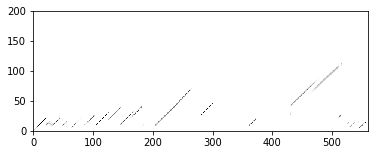

In [3]:
plt.imshow(np.transpose(1-result_probs[1][:,0:200]), cmap='gray', origin='lower')

In [4]:
maxtime = result_probs[1].shape[0]
state_alone_vote = np.zeros(maxtime)
state_together_vote = np.zeros(maxtime)
for i in range(maxtime):
    prob_alone = np.max(result_probs[1][i,1:])
    prob_together = np.max(result_probs[0][i,1:])
    if (prob_alone > prob_together):
        start_est = i - np.argmax(result_probs[1][i,:])
        state_alone_vote[start_est:i+1] = state_alone_vote[start_est:i+1] + 1
    else:      
        start_est = i - np.argmax(result_probs[1][i,:])
        state_together_vote[start_est:i+1] = state_together_vote[start_est:i+1] + 1

#plt.plot(state_type_alone)
#plt.plot(state_start_vote)
state_alone_prob = state_alone_vote / (state_together_vote + state_alone_vote)

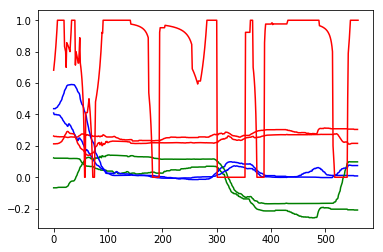

In [5]:
both_arms = np.concatenate((raw_data[relevant_indices,8:11],follower[relevant_indices,0:3]),1)
plt.plot(both_arms)
plt.plot(state_alone_prob)

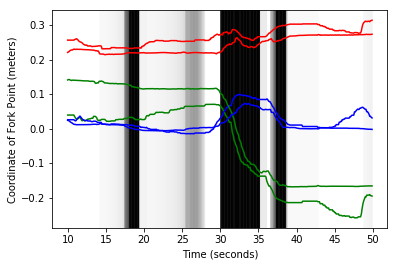

In [9]:
xcoords = raw_data[relevant_indices,0] - raw_data[0,0]
for i in range(100,500):
    plt.axvline(x=xcoords[i],color=str(state_alone_prob[i]))
plt.plot(xcoords[100:500],both_arms[100:500,])
plt.xlabel("Time (seconds)")
plt.ylabel("Coordinate of Fork Point (meters)");